In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Hanoi_Census_2020.csv').loc[:, 'district':]
df.head()

,district,district_id,ward,ward_id,ward_level,area,pop_density,population,children_0_14,female_15_54,male_15_59,elders,no_household,no_household_w_home
0,Huyen Ba Vi,271,Thi tran Tay Dang,9619,Thi tran,12.082,1.290,"15,582","4,346","3,999","4,569","2,668","3,858","3,813"
1,Huyen Ba Vi,271,Xa Ba Trai,9697,Xa,20.173,0.722,"14,558","3,787","4,041","4,433","2,297","3,446","3,407"
2,Huyen Ba Vi,271,Xa Ba Vi,9703,Xa,25.407,0.090,"2,279",561,659,814,245,522,522
3,Huyen Ba Vi,271,Xa Cam Linh,9673,Xa,26.622,0.444,"11,809","3,295","3,006","3,465","2,043","3,156","3,136"
4,Huyen Ba Vi,271,Xa Cam Thuong,9688,Xa,8.274,0.884,"7,312","1,868","1,914","2,165","1,365","1,787","1,759"


### Feature Selection

Hanoi's ward will be clustered based on:
- Population density
- Average number of people per household
- Percentage of children
- Percentage of people in labor age
- Percentage of elders

Those features are comparative and have meaningful insights for ward comparison when clustering

## 1. Data Transformation

* Convert string of number to integer

In [3]:
for i in df.loc[:, 'population':].columns:
    df[i] = df[i].str.replace(',', '')
    
df.loc[:, 'population':] = df.loc[:, 'population':].astype(int)

- Convert age groups: children, people in labor age and elders to percentage format of population

In [4]:
for i in range(8, 12, 1):
    df.iloc[:, i] = df.iloc[:, i] / df['population']
    
df['labor_age'] = df['female_15_54'] + df['male_15_59']

* Calculate number of people per household and delete unnecessary columns

In [5]:
df['average_household'] = df['population'] / df['no_household']
df = df.drop(columns=['district_id', 'ward_level', 'area','population', 'female_15_54', 'male_15_59', 'no_household_w_home', 'no_household'])
df.head()

,district,ward,ward_id,pop_density,children_0_14,elders,labor_age,average_household
0,Huyen Ba Vi,Thi tran Tay Dang,9619,1.290,0.278912,0.171223,0.549865,4.038880
1,Huyen Ba Vi,Xa Ba Trai,9697,0.722,0.260132,0.157783,0.582085,4.224608
2,Huyen Ba Vi,Xa Ba Vi,9703,0.090,0.246161,0.107503,0.646336,4.365900
3,Huyen Ba Vi,Xa Cam Linh,9673,0.444,0.279024,0.173004,0.547972,3.741762
4,Huyen Ba Vi,Xa Cam Thuong,9688,0.884,0.255470,0.186679,0.557850,4.091774


In [6]:
df.describe()

,ward_id,pop_density,children_0_14,elders,labor_age,average_household
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,6013.228522,8.694644,0.238462,0.180978,0.580560,3.728824
std,4729.798802,14.566439,0.043013,0.058632,0.059970,0.374434
min,1.000000,0.090000,0.044301,0.080214,0.283097,2.325817
25%,427.750000,1.282500,0.224744,0.147542,0.568851,3.487877
50%,9629.500000,2.171000,0.248083,0.170316,0.582293,3.718831
75%,10068.250000,6.183000,0.264924,0.195828,0.597792,3.972499
max,10504.000000,95.108000,0.321214,0.461146,0.786440,5.008977


## 2. Standardize data

Data are standardized to have the standard deviation = 1 and mean = 0 so that data are comparable

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = df.loc[:, 'pop_density':].columns
X = df[features]
scaler.fit(X)
X_scaled = scaler.transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features, index=df.index)
df_scaled

,pop_density,children_0_14,elders,labor_age,average_household
0,-0.508773,0.941224,-0.166523,-0.512268,0.828778
1,-0.547801,0.504241,-0.395954,0.025463,1.325227
2,-0.591225,0.179144,-1.254227,1.097758,1.702900
3,-0.566902,0.943852,-0.136131,-0.543867,0.034582
4,-0.536669,0.395774,0.097316,-0.379007,0.970162
...,...,...,...,...,...
577,-0.350946,0.255811,0.321789,-0.498086,0.801339
578,-0.568001,0.911367,-0.274895,-0.384900,-0.941220
579,-0.547182,0.431132,-0.480278,0.160342,0.289872
580,-0.543953,0.535204,-0.047489,-0.337436,0.460078


## 3. Principal Components Analysis

From 5 features, we combine into 2 features, which makes the clustering algorithm more efficient and easy to visualize

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['first_pc', 'second_pc'], index=df.index)
df_pca.head()

,first_pc,second_pc
0,-1.372454,-0.270163
1,-1.054101,-0.647346
2,-0.458634,-1.812505
3,-1.114623,-0.211781
4,-1.075013,-0.010336


## 4. Build clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### Elbow test

I use Elbow test to find the most appropriate number of clusters. I will try two methods: Distortion and Inertia

In [10]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)
 
    distortions.append(np.sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = np.sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

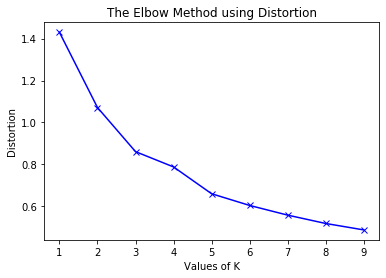

In [11]:
# It is calculated as the average of the squared distances from the cluster centers of the respective clusters. 
# Typically, the Euclidean distance metric is used.

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

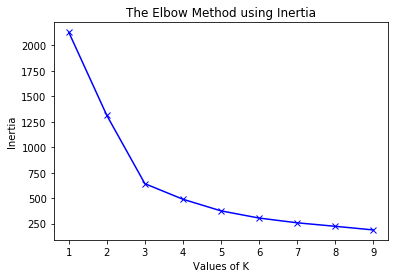

In [12]:
# It is the sum of squared distances of samples to their closest cluster center.

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Build clustering with k = 4

In [13]:
kmeanModel = KMeans(n_clusters=4).fit(df_pca)
df_pca['kmean_group'] = kmeanModel.labels_
df_pca

,first_pc,second_pc,kmean_group
0,-1.372454,-0.270163,0
1,-1.054101,-0.647346,0
2,-0.458634,-1.812505,0
3,-1.114623,-0.211781,0
4,-1.075013,-0.010336,0
...,...,...,...
577,-0.903344,0.316230,0
578,-0.633389,-0.351444,0
579,-0.540351,-0.719093,0
580,-0.933881,-0.159096,0


In [14]:
df['kmean_group'] = df_pca['kmean_group']
df[['first_pc', 'second_pc']] = df_pca[['first_pc', 'second_pc']]
df.head()

,district,ward,ward_id,pop_density,children_0_14,elders,labor_age,average_household,kmean_group,first_pc,second_pc
0,Huyen Ba Vi,Thi tran Tay Dang,9619,1.290,0.278912,0.171223,0.549865,4.038880,0,-1.372454,-0.270163
1,Huyen Ba Vi,Xa Ba Trai,9697,0.722,0.260132,0.157783,0.582085,4.224608,0,-1.054101,-0.647346
2,Huyen Ba Vi,Xa Ba Vi,9703,0.090,0.246161,0.107503,0.646336,4.365900,0,-0.458634,-1.812505
3,Huyen Ba Vi,Xa Cam Linh,9673,0.444,0.279024,0.173004,0.547972,3.741762,0,-1.114623,-0.211781
4,Huyen Ba Vi,Xa Cam Thuong,9688,0.884,0.255470,0.186679,0.557850,4.091774,0,-1.075013,-0.010336


Text(0, 0.5, 'Second principal component')

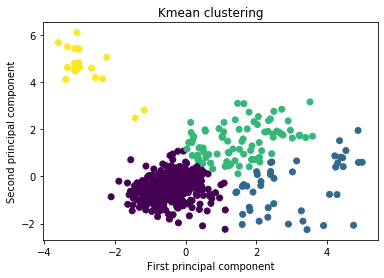

In [15]:
plt.scatter(x=df['first_pc'], y=df['second_pc'], c=df['kmean_group'])
plt.title("Kmean clustering")
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [16]:
# calculate mean values of each group

cluster_group = df.groupby(['kmean_group'])[features].mean()
cluster_group

,pop_density,children_0_14,elders,labor_age,average_household
kmean_group,,,,,
0,2.833545,0.254765,0.161823,0.583412,3.800348
1,28.044523,0.160998,0.154750,0.684252,3.353800
2,30.087059,0.190635,0.235453,0.573911,3.509324
3,2.166636,0.258787,0.398239,0.342975,3.925719


## 5. Visualization on map

In [17]:
!pip install plotly
import json
import plotly.express as px

In [18]:
file = open('Hanoi_new_location.json', encoding='utf8')
geojson = json.load(file)

df['ward_id'] = df['ward_id'].astype('str')
df['kmean_group'] = df['kmean_group'].astype('str')
features = geojson['features']

# Add ward id to geojson
for y in range(len(features)):
    for x in range(len(df.index)):
        if (df.loc[x, 'ward'] == features[y]["properties"]["Name"]) and (df.loc[x, 'district'] == features[y]["properties"]["Quan"]):
            features[y]["id"] = df.loc[x, 'ward_id']

In [ ]:
px.set_mapbox_access_token(
        "pk.eyJ1IjoiaGFtaWJvIiwiYSI6ImNrN2N2Ym5uYTAybzEzb256cmk2NGtjeTUifQ.3qaqDjFrZdS3sqeoPeJG-w")

fig = px.choropleth_mapbox(df, geojson=geojson, locations='ward_id', color='kmean_group',
                           hover_name='ward', center={'lat': 21.0278, 'lon': 105.8342},
                           color_discrete_sequence=px.colors.qualitative.G10,
                           zoom=8)

fig.update_layout(legend=dict(
    yanchor='top', xanchor='left', y=1, x=1, orientation='v'))
fig.update_layout(mapbox_style='light')
fig.update_layout(width=800, height=600)
fig.update_traces(marker_line=dict(width=1, color='white'))

fig.show()

*Due to the limit upload size, I cannot show the visualization in the notebook. Please go to the link for the visualization capture: https://github.com/hoanglinh171/Hanoi-ward-clustering/blob/main/image.png*

### Interpretation

From cluster_group result, we can segment wards in Hanoi into 4 cluster:
- Group 0: Rural area, sparsely populated but with high ratio of labor-aged population (58%) and high ratio of children (25%)
- Group 1: Newly-urbanized area, densely populated, significantly high ratio of labor-aged population (average 68%)
- Group 2: Urban area or town, densely populated, high ratio of labor-aged population (57%) and medium number of elders (23%)
- Group 3: Rural area, sparsely populated, high ratio of elders (39%) and children (25%)